In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 239318 images
Dataset type val label type: species


Loaded 59836 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 97692 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 qlos1y5g


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-qlos1y5g:best, 58.50MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                           | 0/1870 [00:00<?, ?it/s]

  0%|                                                                                                                                                   | 1/1870 [00:01<33:56,  1.09s/it]

  0%|▍                                                                                                                                                  | 6/1870 [00:01<04:47,  6.48it/s]

  1%|▊                                                                                                                                                 | 11/1870 [00:01<02:31, 12.30it/s]

  1%|█▏                                                                                                                                                | 16/1870 [00:01<01:42, 18.03it/s]

  1%|█▋                                                                                                                                                | 21/1870 [00:01<01:19, 23.32it/s]

  1%|██                                                                                                                                                | 26/1870 [00:01<01:05, 27.95it/s]

  2%|██▍                                                                                                                                               | 31/1870 [00:01<00:57, 31.79it/s]

  2%|██▊                                                                                                                                               | 36/1870 [00:01<00:52, 34.86it/s]

  2%|███▏                                                                                                                                              | 41/1870 [00:02<00:49, 37.22it/s]

  2%|███▌                                                                                                                                              | 46/1870 [00:02<00:46, 39.01it/s]

  3%|███▉                                                                                                                                              | 51/1870 [00:02<00:45, 40.29it/s]

  3%|████▎                                                                                                                                             | 56/1870 [00:02<00:43, 41.23it/s]

  3%|████▊                                                                                                                                             | 61/1870 [00:02<00:43, 41.94it/s]

  4%|█████▏                                                                                                                                            | 66/1870 [00:02<00:42, 42.43it/s]

  4%|█████▌                                                                                                                                            | 71/1870 [00:02<00:42, 42.78it/s]

  4%|█████▉                                                                                                                                            | 76/1870 [00:02<00:41, 43.02it/s]

  4%|██████▎                                                                                                                                           | 81/1870 [00:02<00:41, 43.20it/s]

  5%|██████▋                                                                                                                                           | 86/1870 [00:03<00:41, 43.31it/s]

  5%|███████                                                                                                                                           | 91/1870 [00:03<00:40, 43.40it/s]

  5%|███████▍                                                                                                                                          | 96/1870 [00:03<00:40, 43.45it/s]

  5%|███████▊                                                                                                                                         | 101/1870 [00:03<00:40, 43.49it/s]

  6%|████████▏                                                                                                                                        | 106/1870 [00:03<00:40, 43.52it/s]

  6%|████████▌                                                                                                                                        | 111/1870 [00:03<00:40, 43.55it/s]

  6%|████████▉                                                                                                                                        | 116/1870 [00:03<00:40, 43.59it/s]

  6%|█████████▍                                                                                                                                       | 121/1870 [00:03<00:40, 43.60it/s]

  7%|█████████▊                                                                                                                                       | 126/1870 [00:03<00:39, 43.60it/s]

  7%|██████████▏                                                                                                                                      | 131/1870 [00:04<00:39, 43.63it/s]

  7%|██████████▌                                                                                                                                      | 136/1870 [00:04<00:39, 43.63it/s]

  8%|██████████▉                                                                                                                                      | 141/1870 [00:04<00:39, 43.67it/s]

  8%|███████████▎                                                                                                                                     | 146/1870 [00:04<00:39, 43.65it/s]

  8%|███████████▋                                                                                                                                     | 151/1870 [00:04<00:39, 43.66it/s]

  8%|████████████                                                                                                                                     | 156/1870 [00:04<00:39, 43.67it/s]

  9%|████████████▍                                                                                                                                    | 161/1870 [00:04<00:39, 43.66it/s]

  9%|████████████▊                                                                                                                                    | 166/1870 [00:04<00:39, 43.67it/s]

  9%|█████████████▎                                                                                                                                   | 171/1870 [00:04<00:38, 43.67it/s]

  9%|█████████████▋                                                                                                                                   | 176/1870 [00:05<00:38, 43.65it/s]

 10%|██████████████                                                                                                                                   | 181/1870 [00:05<00:38, 43.66it/s]

 10%|██████████████▍                                                                                                                                  | 186/1870 [00:05<00:38, 43.67it/s]

 10%|██████████████▊                                                                                                                                  | 191/1870 [00:05<00:38, 43.67it/s]

 10%|███████████████▏                                                                                                                                 | 196/1870 [00:05<00:38, 43.62it/s]

 11%|███████████████▌                                                                                                                                 | 201/1870 [00:05<00:38, 43.65it/s]

 11%|███████████████▉                                                                                                                                 | 206/1870 [00:05<00:38, 43.65it/s]

 11%|████████████████▎                                                                                                                                | 211/1870 [00:05<00:38, 43.65it/s]

 12%|████████████████▋                                                                                                                                | 216/1870 [00:06<00:37, 43.65it/s]

 12%|█████████████████▏                                                                                                                               | 221/1870 [00:06<00:37, 43.64it/s]

 12%|█████████████████▌                                                                                                                               | 226/1870 [00:06<00:37, 43.64it/s]

 12%|█████████████████▉                                                                                                                               | 231/1870 [00:06<00:37, 43.66it/s]

 13%|██████████████████▎                                                                                                                              | 236/1870 [00:06<00:37, 43.65it/s]

 13%|██████████████████▋                                                                                                                              | 241/1870 [00:06<00:37, 43.67it/s]

 13%|███████████████████                                                                                                                              | 246/1870 [00:06<00:37, 43.66it/s]

 13%|███████████████████▍                                                                                                                             | 251/1870 [00:06<00:37, 43.64it/s]

 14%|███████████████████▊                                                                                                                             | 256/1870 [00:06<00:36, 43.66it/s]

 14%|████████████████████▏                                                                                                                            | 261/1870 [00:07<00:36, 43.65it/s]

 14%|████████████████████▋                                                                                                                            | 266/1870 [00:07<00:36, 43.67it/s]

 14%|█████████████████████                                                                                                                            | 271/1870 [00:07<00:36, 43.66it/s]

 15%|█████████████████████▍                                                                                                                           | 276/1870 [00:07<00:36, 43.67it/s]

 15%|█████████████████████▊                                                                                                                           | 281/1870 [00:07<00:36, 43.66it/s]

 15%|██████████████████████▏                                                                                                                          | 286/1870 [00:07<00:36, 43.65it/s]

 16%|██████████████████████▌                                                                                                                          | 291/1870 [00:07<00:36, 43.66it/s]

 16%|██████████████████████▉                                                                                                                          | 296/1870 [00:07<00:36, 43.68it/s]

 16%|███████████████████████▎                                                                                                                         | 301/1870 [00:07<00:35, 43.68it/s]

 16%|███████████████████████▋                                                                                                                         | 306/1870 [00:08<00:35, 43.67it/s]

 17%|████████████████████████                                                                                                                         | 311/1870 [00:08<00:35, 43.67it/s]

 17%|████████████████████████▌                                                                                                                        | 316/1870 [00:08<00:35, 43.67it/s]

 17%|████████████████████████▉                                                                                                                        | 321/1870 [00:08<00:35, 43.65it/s]

 17%|█████████████████████████▎                                                                                                                       | 326/1870 [00:08<00:35, 43.63it/s]

 18%|█████████████████████████▋                                                                                                                       | 331/1870 [00:08<00:35, 43.64it/s]

 18%|██████████████████████████                                                                                                                       | 336/1870 [00:08<00:35, 43.66it/s]

 18%|██████████████████████████▍                                                                                                                      | 341/1870 [00:08<00:35, 43.65it/s]

 19%|██████████████████████████▊                                                                                                                      | 346/1870 [00:08<00:34, 43.68it/s]

 19%|███████████████████████████▏                                                                                                                     | 351/1870 [00:09<00:34, 43.68it/s]

 19%|███████████████████████████▌                                                                                                                     | 356/1870 [00:09<00:34, 43.67it/s]

 19%|███████████████████████████▉                                                                                                                     | 361/1870 [00:09<00:34, 43.64it/s]

 20%|████████████████████████████▍                                                                                                                    | 366/1870 [00:09<00:34, 43.66it/s]

 20%|████████████████████████████▊                                                                                                                    | 371/1870 [00:09<00:34, 43.66it/s]

 20%|█████████████████████████████▏                                                                                                                   | 376/1870 [00:09<00:34, 43.65it/s]

 20%|█████████████████████████████▌                                                                                                                   | 381/1870 [00:09<00:34, 43.67it/s]

 21%|█████████████████████████████▉                                                                                                                   | 386/1870 [00:09<00:33, 43.69it/s]

 21%|██████████████████████████████▎                                                                                                                  | 391/1870 [00:10<00:33, 43.68it/s]

 21%|██████████████████████████████▋                                                                                                                  | 396/1870 [00:10<00:33, 43.67it/s]

 21%|███████████████████████████████                                                                                                                  | 401/1870 [00:10<00:33, 43.69it/s]

 22%|███████████████████████████████▍                                                                                                                 | 406/1870 [00:10<00:33, 43.66it/s]

 22%|███████████████████████████████▊                                                                                                                 | 411/1870 [00:10<00:33, 43.67it/s]

 22%|████████████████████████████████▎                                                                                                                | 416/1870 [00:10<00:33, 43.67it/s]

 23%|████████████████████████████████▋                                                                                                                | 421/1870 [00:10<00:33, 43.68it/s]

 23%|█████████████████████████████████                                                                                                                | 426/1870 [00:10<00:33, 43.69it/s]

 23%|█████████████████████████████████▍                                                                                                               | 431/1870 [00:10<00:32, 43.70it/s]

 23%|█████████████████████████████████▊                                                                                                               | 436/1870 [00:11<00:32, 43.67it/s]

 24%|██████████████████████████████████▏                                                                                                              | 441/1870 [00:11<00:32, 43.70it/s]

 24%|██████████████████████████████████▌                                                                                                              | 446/1870 [00:11<00:32, 43.69it/s]

 24%|██████████████████████████████████▉                                                                                                              | 451/1870 [00:11<00:32, 43.67it/s]

 24%|███████████████████████████████████▎                                                                                                             | 456/1870 [00:11<00:32, 43.62it/s]

 25%|███████████████████████████████████▋                                                                                                             | 461/1870 [00:11<00:32, 43.65it/s]

 25%|████████████████████████████████████▏                                                                                                            | 466/1870 [00:11<00:32, 43.65it/s]

 25%|████████████████████████████████████▌                                                                                                            | 471/1870 [00:11<00:32, 43.66it/s]

 25%|████████████████████████████████████▉                                                                                                            | 476/1870 [00:11<00:31, 43.66it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 481/1870 [00:12<00:31, 43.66it/s]

 26%|█████████████████████████████████████▋                                                                                                           | 486/1870 [00:12<00:31, 43.69it/s]

 26%|██████████████████████████████████████                                                                                                           | 491/1870 [00:12<00:31, 43.68it/s]

 27%|██████████████████████████████████████▍                                                                                                          | 496/1870 [00:12<00:31, 43.69it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 501/1870 [00:12<00:31, 43.65it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 506/1870 [00:12<00:31, 43.65it/s]

 27%|███████████████████████████████████████▌                                                                                                         | 511/1870 [00:12<00:31, 43.64it/s]

 28%|████████████████████████████████████████                                                                                                         | 516/1870 [00:12<00:31, 43.65it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 521/1870 [00:13<00:30, 43.66it/s]

 28%|████████████████████████████████████████▊                                                                                                        | 526/1870 [00:13<00:30, 43.66it/s]

 28%|█████████████████████████████████████████▏                                                                                                       | 531/1870 [00:13<00:30, 43.66it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 536/1870 [00:13<00:30, 43.68it/s]

 29%|█████████████████████████████████████████▉                                                                                                       | 541/1870 [00:13<00:30, 43.68it/s]

 29%|██████████████████████████████████████████▎                                                                                                      | 546/1870 [00:13<00:30, 43.67it/s]

 29%|██████████████████████████████████████████▋                                                                                                      | 551/1870 [00:13<00:30, 43.68it/s]

 30%|███████████████████████████████████████████                                                                                                      | 556/1870 [00:13<00:30, 43.68it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 561/1870 [00:13<00:29, 43.68it/s]

 30%|███████████████████████████████████████████▉                                                                                                     | 566/1870 [00:14<00:29, 43.67it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 571/1870 [00:14<00:29, 43.67it/s]

 31%|████████████████████████████████████████████▋                                                                                                    | 576/1870 [00:14<00:29, 43.63it/s]

 31%|█████████████████████████████████████████████                                                                                                    | 581/1870 [00:14<00:29, 43.65it/s]

 31%|█████████████████████████████████████████████▍                                                                                                   | 586/1870 [00:14<00:29, 43.67it/s]

 32%|█████████████████████████████████████████████▊                                                                                                   | 591/1870 [00:14<00:29, 43.68it/s]

 32%|██████████████████████████████████████████████▏                                                                                                  | 596/1870 [00:14<00:29, 43.68it/s]

 32%|██████████████████████████████████████████████▌                                                                                                  | 601/1870 [00:14<00:29, 43.70it/s]

 32%|██████████████████████████████████████████████▉                                                                                                  | 606/1870 [00:14<00:28, 43.70it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 611/1870 [00:15<00:28, 43.69it/s]

 33%|███████████████████████████████████████████████▊                                                                                                 | 616/1870 [00:15<00:28, 43.69it/s]

 33%|████████████████████████████████████████████████▏                                                                                                | 621/1870 [00:15<00:28, 43.68it/s]

 33%|████████████████████████████████████████████████▌                                                                                                | 626/1870 [00:15<00:28, 43.68it/s]

 34%|████████████████████████████████████████████████▉                                                                                                | 631/1870 [00:15<00:28, 43.68it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 636/1870 [00:15<00:28, 43.68it/s]

 34%|█████████████████████████████████████████████████▋                                                                                               | 641/1870 [00:15<00:28, 43.67it/s]

 35%|██████████████████████████████████████████████████                                                                                               | 646/1870 [00:15<00:28, 43.64it/s]

 35%|██████████████████████████████████████████████████▍                                                                                              | 651/1870 [00:15<00:27, 43.66it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 656/1870 [00:16<00:27, 43.68it/s]

 35%|███████████████████████████████████████████████████▎                                                                                             | 661/1870 [00:16<00:27, 43.66it/s]

 36%|███████████████████████████████████████████████████▋                                                                                             | 666/1870 [00:16<00:27, 43.66it/s]

 36%|████████████████████████████████████████████████████                                                                                             | 671/1870 [00:16<00:27, 43.66it/s]

 36%|████████████████████████████████████████████████████▍                                                                                            | 676/1870 [00:16<00:27, 43.68it/s]

 36%|████████████████████████████████████████████████████▊                                                                                            | 681/1870 [00:16<00:27, 43.68it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 686/1870 [00:16<00:27, 43.69it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                           | 691/1870 [00:16<00:26, 43.68it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                           | 696/1870 [00:17<00:26, 43.68it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                          | 701/1870 [00:17<00:26, 43.67it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                          | 706/1870 [00:17<00:26, 43.69it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                         | 711/1870 [00:17<00:26, 43.70it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                         | 716/1870 [00:17<00:26, 43.69it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                         | 721/1870 [00:17<00:26, 43.69it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                        | 726/1870 [00:17<00:26, 43.69it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                        | 731/1870 [00:17<00:26, 43.61it/s]

 39%|█████████████████████████████████████████████████████████                                                                                        | 736/1870 [00:17<00:25, 43.62it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                       | 741/1870 [00:18<00:25, 43.65it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                       | 746/1870 [00:18<00:25, 43.67it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                      | 751/1870 [00:18<00:25, 43.67it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                      | 756/1870 [00:18<00:25, 43.67it/s]

 41%|███████████████████████████████████████████████████████████                                                                                      | 761/1870 [00:18<00:25, 43.67it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                     | 766/1870 [00:18<00:25, 43.68it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                     | 771/1870 [00:18<00:25, 43.69it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                    | 776/1870 [00:18<00:25, 43.69it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                    | 781/1870 [00:18<00:24, 43.67it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                    | 786/1870 [00:19<00:24, 43.66it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                   | 791/1870 [00:19<00:24, 43.67it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                   | 796/1870 [00:19<00:24, 43.66it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                   | 801/1870 [00:19<00:24, 43.65it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                  | 806/1870 [00:19<00:24, 43.67it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 811/1870 [00:19<00:24, 43.69it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                 | 816/1870 [00:19<00:24, 43.68it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                 | 821/1870 [00:19<00:24, 43.62it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                 | 826/1870 [00:19<00:23, 43.65it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                | 831/1870 [00:20<00:23, 43.64it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                                | 836/1870 [00:20<00:23, 43.66it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                               | 841/1870 [00:20<00:23, 43.68it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                               | 846/1870 [00:20<00:23, 43.67it/s]

 46%|█████████████████████████████████████████████████████████████████▉                                                                               | 851/1870 [00:20<00:23, 43.68it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                              | 856/1870 [00:20<00:23, 43.68it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                              | 861/1870 [00:20<00:23, 43.68it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                             | 866/1870 [00:20<00:22, 43.68it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                             | 871/1870 [00:21<00:22, 43.69it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                             | 876/1870 [00:21<00:22, 43.70it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                            | 881/1870 [00:21<00:22, 43.71it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 886/1870 [00:21<00:22, 43.70it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                            | 891/1870 [00:21<00:22, 43.70it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                           | 896/1870 [00:21<00:22, 43.70it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                           | 901/1870 [00:21<00:22, 43.71it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                          | 906/1870 [00:21<00:22, 43.70it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                          | 911/1870 [00:21<00:21, 43.70it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                          | 916/1870 [00:22<00:21, 43.68it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                         | 921/1870 [00:22<00:21, 43.62it/s]

 50%|███████████████████████████████████████████████████████████████████████▊                                                                         | 926/1870 [00:22<00:21, 43.64it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                        | 931/1870 [00:22<00:21, 43.66it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 936/1870 [00:22<00:21, 43.66it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                        | 941/1870 [00:22<00:21, 43.67it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                       | 946/1870 [00:22<00:21, 43.67it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                       | 951/1870 [00:22<00:21, 43.69it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                      | 956/1870 [00:22<00:20, 43.66it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                      | 961/1870 [00:23<00:20, 43.66it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                      | 966/1870 [00:23<00:20, 43.67it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 971/1870 [00:23<00:20, 43.67it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                     | 976/1870 [00:23<00:20, 43.66it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                     | 981/1870 [00:23<00:20, 43.67it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                    | 986/1870 [00:23<00:20, 43.68it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                    | 991/1870 [00:23<00:20, 43.68it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                   | 996/1870 [00:23<00:20, 43.68it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 1001/1870 [00:23<00:19, 43.68it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                  | 1006/1870 [00:24<00:19, 43.67it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 1011/1870 [00:24<00:19, 43.67it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                 | 1016/1870 [00:24<00:19, 43.69it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                 | 1021/1870 [00:24<00:19, 43.69it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                 | 1026/1870 [00:24<00:19, 43.69it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                | 1031/1870 [00:24<00:19, 43.68it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                | 1036/1870 [00:24<00:19, 43.67it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▏                                                               | 1041/1870 [00:24<00:19, 43.59it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                               | 1046/1870 [00:25<00:18, 43.61it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▉                                                               | 1051/1870 [00:25<00:18, 43.65it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                              | 1056/1870 [00:25<00:18, 43.67it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                              | 1061/1870 [00:25<00:18, 43.69it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 1066/1870 [00:25<00:18, 43.69it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                             | 1071/1870 [00:25<00:18, 43.68it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                             | 1076/1870 [00:25<00:18, 43.67it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                            | 1081/1870 [00:25<00:18, 43.67it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                            | 1086/1870 [00:25<00:17, 43.69it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 1091/1870 [00:26<00:17, 43.70it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1096/1870 [00:26<00:17, 43.70it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1101/1870 [00:26<00:17, 43.68it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1106/1870 [00:26<00:17, 43.68it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1111/1870 [00:26<00:17, 43.67it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1116/1870 [00:26<00:17, 43.67it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1121/1870 [00:26<00:17, 43.68it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1126/1870 [00:26<00:17, 43.70it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 1131/1870 [00:26<00:16, 43.68it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1136/1870 [00:27<00:16, 43.69it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1141/1870 [00:27<00:16, 43.69it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1146/1870 [00:27<00:16, 43.68it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1151/1870 [00:27<00:16, 43.67it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 1156/1870 [00:27<00:16, 43.68it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1161/1870 [00:27<00:16, 43.68it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1166/1870 [00:27<00:16, 43.69it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1171/1870 [00:27<00:16, 43.57it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1176/1870 [00:28<00:15, 43.60it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1181/1870 [00:28<00:15, 43.63it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1186/1870 [00:28<00:15, 43.65it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1191/1870 [00:28<00:15, 43.66it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1196/1870 [00:28<00:15, 43.68it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1201/1870 [00:28<00:15, 43.70it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1206/1870 [00:28<00:15, 43.69it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1211/1870 [00:28<00:15, 43.69it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1216/1870 [00:28<00:14, 43.70it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1221/1870 [00:29<00:14, 43.68it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1226/1870 [00:29<00:14, 43.69it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1231/1870 [00:29<00:14, 43.71it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1236/1870 [00:29<00:14, 43.70it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1241/1870 [00:29<00:14, 43.70it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1246/1870 [00:29<00:14, 43.70it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1251/1870 [00:29<00:14, 43.68it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1256/1870 [00:29<00:14, 43.68it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1261/1870 [00:29<00:13, 43.69it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1266/1870 [00:30<00:13, 43.69it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1271/1870 [00:30<00:13, 43.68it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1276/1870 [00:30<00:13, 43.69it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1281/1870 [00:30<00:13, 43.68it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1286/1870 [00:30<00:13, 43.68it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1291/1870 [00:30<00:13, 43.68it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1296/1870 [00:30<00:13, 43.66it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1301/1870 [00:30<00:13, 43.64it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1306/1870 [00:30<00:12, 43.63it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1311/1870 [00:31<00:12, 43.64it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1316/1870 [00:31<00:12, 43.57it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1321/1870 [00:31<00:12, 43.60it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1326/1870 [00:31<00:12, 43.60it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1331/1870 [00:31<00:12, 43.60it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1336/1870 [00:31<00:12, 43.60it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1341/1870 [00:31<00:12, 43.63it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1346/1870 [00:31<00:12, 43.64it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1351/1870 [00:32<00:11, 43.65it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1356/1870 [00:32<00:11, 43.65it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1361/1870 [00:32<00:11, 43.65it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1366/1870 [00:32<00:11, 43.65it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1371/1870 [00:32<00:11, 43.64it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1376/1870 [00:32<00:11, 43.63it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1381/1870 [00:32<00:11, 43.65it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1386/1870 [00:32<00:11, 43.65it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1391/1870 [00:32<00:10, 43.66it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1396/1870 [00:33<00:10, 43.65it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1401/1870 [00:33<00:10, 43.67it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1406/1870 [00:33<00:10, 43.67it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1411/1870 [00:33<00:10, 43.66it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1416/1870 [00:33<00:10, 43.65it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1421/1870 [00:33<00:10, 43.66it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1426/1870 [00:33<00:10, 43.64it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1431/1870 [00:33<00:10, 43.65it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1436/1870 [00:33<00:09, 43.65it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1441/1870 [00:34<00:09, 43.66it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1446/1870 [00:34<00:09, 43.64it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1451/1870 [00:34<00:09, 43.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1456/1870 [00:34<00:09, 43.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1461/1870 [00:34<00:09, 43.63it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1466/1870 [00:34<00:09, 43.65it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1471/1870 [00:34<00:09, 43.65it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1476/1870 [00:34<00:09, 43.66it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1481/1870 [00:34<00:08, 43.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1486/1870 [00:35<00:08, 43.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1491/1870 [00:35<00:08, 43.60it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1496/1870 [00:35<00:08, 43.63it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1501/1870 [00:35<00:08, 43.64it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1506/1870 [00:35<00:08, 43.64it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1511/1870 [00:35<00:08, 43.64it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1516/1870 [00:35<00:08, 43.64it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1521/1870 [00:35<00:07, 43.64it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1526/1870 [00:36<00:07, 43.65it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1531/1870 [00:36<00:07, 43.67it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1536/1870 [00:36<00:07, 43.67it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1541/1870 [00:36<00:07, 43.67it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1546/1870 [00:36<00:07, 43.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1551/1870 [00:36<00:07, 43.66it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1556/1870 [00:36<00:07, 43.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1561/1870 [00:36<00:07, 43.65it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1566/1870 [00:36<00:06, 43.67it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1571/1870 [00:37<00:06, 43.66it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1576/1870 [00:37<00:06, 43.67it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1581/1870 [00:37<00:06, 43.67it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1586/1870 [00:37<00:06, 43.63it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1591/1870 [00:37<00:06, 43.65it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1596/1870 [00:37<00:06, 43.64it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1601/1870 [00:37<00:06, 43.66it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1606/1870 [00:37<00:06, 43.67it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1611/1870 [00:37<00:05, 43.68it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1616/1870 [00:38<00:05, 43.67it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1621/1870 [00:38<00:05, 43.65it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1626/1870 [00:38<00:05, 43.66it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1631/1870 [00:38<00:05, 43.65it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1636/1870 [00:38<00:05, 43.65it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1641/1870 [00:38<00:05, 43.65it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1646/1870 [00:38<00:05, 43.66it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1651/1870 [00:38<00:05, 43.66it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1656/1870 [00:39<00:04, 43.66it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1661/1870 [00:39<00:04, 43.67it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1666/1870 [00:39<00:04, 43.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1671/1870 [00:39<00:04, 43.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1676/1870 [00:39<00:04, 43.60it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1681/1870 [00:39<00:04, 43.63it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1686/1870 [00:39<00:04, 43.64it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1691/1870 [00:39<00:04, 43.66it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1696/1870 [00:39<00:03, 43.66it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1701/1870 [00:40<00:03, 43.66it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1706/1870 [00:40<00:03, 43.66it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1711/1870 [00:40<00:03, 43.66it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1716/1870 [00:40<00:03, 43.66it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1721/1870 [00:40<00:03, 43.68it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1726/1870 [00:40<00:03, 43.68it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1731/1870 [00:40<00:03, 43.67it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1736/1870 [00:40<00:03, 43.65it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1741/1870 [00:40<00:02, 43.66it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1746/1870 [00:41<00:02, 43.64it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1751/1870 [00:41<00:02, 43.64it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1756/1870 [00:41<00:02, 43.65it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1761/1870 [00:41<00:02, 43.65it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1766/1870 [00:41<00:02, 43.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1771/1870 [00:41<00:02, 43.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1776/1870 [00:41<00:02, 43.65it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1781/1870 [00:41<00:02, 43.63it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1786/1870 [00:41<00:01, 43.65it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1791/1870 [00:42<00:01, 43.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1796/1870 [00:42<00:01, 43.65it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1801/1870 [00:42<00:01, 43.65it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1806/1870 [00:42<00:01, 43.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1811/1870 [00:42<00:01, 43.64it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1816/1870 [00:42<00:01, 43.63it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1821/1870 [00:42<00:01, 43.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1826/1870 [00:42<00:01, 43.66it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1831/1870 [00:43<00:00, 43.67it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1836/1870 [00:43<00:00, 43.66it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1841/1870 [00:43<00:00, 43.65it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1846/1870 [00:43<00:00, 43.64it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1851/1870 [00:43<00:00, 43.64it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1856/1870 [00:43<00:00, 43.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1861/1870 [00:43<00:00, 43.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1866/1870 [00:43<00:00, 42.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [00:43<00:00, 42.54it/s]

train - OK


  0%|                                                                                                                                                            | 0/468 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                   | 1/468 [00:00<02:46,  2.80it/s]

  1%|█▉                                                                                                                                                  | 6/468 [00:00<00:29, 15.55it/s]

  2%|███▍                                                                                                                                               | 11/468 [00:00<00:18, 24.15it/s]

  3%|█████                                                                                                                                              | 16/468 [00:00<00:15, 30.02it/s]

  4%|██████▌                                                                                                                                            | 21/468 [00:00<00:13, 34.05it/s]

  6%|████████▏                                                                                                                                          | 26/468 [00:00<00:11, 36.85it/s]

  7%|█████████▋                                                                                                                                         | 31/468 [00:01<00:11, 38.81it/s]

  8%|███████████▎                                                                                                                                       | 36/468 [00:01<00:10, 40.16it/s]

  9%|████████████▉                                                                                                                                      | 41/468 [00:01<00:10, 41.10it/s]

 10%|██████████████▍                                                                                                                                    | 46/468 [00:01<00:10, 41.74it/s]

 11%|████████████████                                                                                                                                   | 51/468 [00:01<00:09, 42.22it/s]

 12%|█████████████████▌                                                                                                                                 | 56/468 [00:01<00:09, 42.57it/s]

 13%|███████████████████▏                                                                                                                               | 61/468 [00:01<00:09, 42.79it/s]

 14%|████████████████████▋                                                                                                                              | 66/468 [00:01<00:09, 42.95it/s]

 15%|██████████████████████▎                                                                                                                            | 71/468 [00:01<00:09, 43.06it/s]

 16%|███████████████████████▊                                                                                                                           | 76/468 [00:02<00:09, 43.13it/s]

 17%|█████████████████████████▍                                                                                                                         | 81/468 [00:02<00:08, 43.19it/s]

 18%|███████████████████████████                                                                                                                        | 86/468 [00:02<00:08, 43.23it/s]

 19%|████████████████████████████▌                                                                                                                      | 91/468 [00:02<00:08, 43.28it/s]

 21%|██████████████████████████████▏                                                                                                                    | 96/468 [00:02<00:08, 43.27it/s]

 22%|███████████████████████████████▌                                                                                                                  | 101/468 [00:02<00:08, 43.10it/s]

 23%|█████████████████████████████████                                                                                                                 | 106/468 [00:02<00:08, 43.13it/s]

 24%|██████████████████████████████████▋                                                                                                               | 111/468 [00:02<00:08, 43.20it/s]

 25%|████████████████████████████████████▏                                                                                                             | 116/468 [00:03<00:08, 43.25it/s]

 26%|█████████████████████████████████████▋                                                                                                            | 121/468 [00:03<00:08, 43.27it/s]

 27%|███████████████████████████████████████▎                                                                                                          | 126/468 [00:03<00:07, 43.30it/s]

 28%|████████████████████████████████████████▊                                                                                                         | 131/468 [00:03<00:07, 43.33it/s]

 29%|██████████████████████████████████████████▍                                                                                                       | 136/468 [00:03<00:07, 43.32it/s]

 30%|███████████████████████████████████████████▉                                                                                                      | 141/468 [00:03<00:07, 43.33it/s]

 31%|█████████████████████████████████████████████▌                                                                                                    | 146/468 [00:03<00:07, 43.34it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 151/468 [00:03<00:07, 43.35it/s]

 33%|████████████████████████████████████████████████▋                                                                                                 | 156/468 [00:03<00:07, 43.30it/s]

 34%|██████████████████████████████████████████████████▏                                                                                               | 161/468 [00:04<00:07, 43.33it/s]

 35%|███████████████████████████████████████████████████▊                                                                                              | 166/468 [00:04<00:06, 43.32it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                            | 171/468 [00:04<00:06, 43.33it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                           | 176/468 [00:04<00:06, 43.27it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                         | 181/468 [00:04<00:06, 43.29it/s]

 40%|██████████████████████████████████████████████████████████                                                                                        | 186/468 [00:04<00:06, 43.29it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                      | 191/468 [00:04<00:06, 43.32it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                    | 196/468 [00:04<00:06, 43.28it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                   | 201/468 [00:04<00:06, 43.27it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                 | 206/468 [00:05<00:06, 43.31it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                | 211/468 [00:05<00:05, 43.32it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                              | 216/468 [00:05<00:05, 43.34it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                             | 221/468 [00:05<00:05, 43.29it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                           | 226/468 [00:05<00:05, 43.30it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                          | 231/468 [00:05<00:05, 43.31it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 236/468 [00:05<00:05, 43.33it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 241/468 [00:05<00:05, 43.33it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 246/468 [00:06<00:05, 43.34it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 251/468 [00:06<00:05, 43.26it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                  | 256/468 [00:06<00:04, 43.29it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 261/468 [00:06<00:04, 43.30it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                               | 266/468 [00:06<00:04, 43.32it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 271/468 [00:06<00:04, 43.31it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                            | 276/468 [00:06<00:04, 43.33it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                          | 281/468 [00:06<00:04, 43.29it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 286/468 [00:06<00:04, 43.32it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 291/468 [00:07<00:04, 43.32it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 296/468 [00:07<00:03, 43.30it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 301/468 [00:07<00:03, 43.34it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 306/468 [00:07<00:03, 43.34it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 311/468 [00:07<00:03, 43.35it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 316/468 [00:07<00:03, 43.35it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 321/468 [00:07<00:03, 43.35it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 326/468 [00:07<00:03, 43.34it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 331/468 [00:07<00:03, 43.35it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 336/468 [00:08<00:03, 43.35it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 341/468 [00:08<00:02, 43.35it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 346/468 [00:08<00:02, 43.36it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 351/468 [00:08<00:02, 43.35it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 356/468 [00:08<00:02, 43.37it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 361/468 [00:08<00:02, 43.32it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 366/468 [00:08<00:02, 43.34it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 371/468 [00:08<00:02, 43.36it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 376/468 [00:09<00:02, 43.31it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 381/468 [00:09<00:02, 43.32it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 386/468 [00:09<00:01, 43.32it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 391/468 [00:09<00:01, 43.31it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 396/468 [00:09<00:01, 43.33it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 401/468 [00:09<00:01, 43.32it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 406/468 [00:09<00:01, 43.31it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 411/468 [00:09<00:01, 43.33it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 416/468 [00:09<00:01, 43.30it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 421/468 [00:10<00:01, 43.30it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 426/468 [00:10<00:00, 43.31it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 431/468 [00:10<00:00, 43.32it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 436/468 [00:10<00:00, 43.34it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 441/468 [00:10<00:00, 43.33it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 446/468 [00:10<00:00, 43.35it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 451/468 [00:10<00:00, 43.34it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 456/468 [00:10<00:00, 43.29it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 461/468 [00:10<00:00, 43.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 466/468 [00:11<00:00, 43.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:11<00:00, 41.47it/s]

val - OK


  0%|                                                                                                                                                            | 0/764 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                   | 1/764 [00:00<05:19,  2.39it/s]

  1%|█▏                                                                                                                                                  | 6/764 [00:00<00:54, 13.90it/s]

  1%|██                                                                                                                                                 | 11/764 [00:00<00:33, 22.29it/s]

  2%|███                                                                                                                                                | 16/764 [00:00<00:26, 28.35it/s]

  3%|████                                                                                                                                               | 21/764 [00:00<00:22, 32.67it/s]

  3%|█████                                                                                                                                              | 26/764 [00:01<00:20, 35.75it/s]

  4%|█████▉                                                                                                                                             | 31/764 [00:01<00:19, 37.92it/s]

  5%|██████▉                                                                                                                                            | 36/764 [00:01<00:18, 39.47it/s]

  5%|███████▉                                                                                                                                           | 41/764 [00:01<00:17, 40.55it/s]

  6%|████████▊                                                                                                                                          | 46/764 [00:01<00:17, 41.33it/s]

  7%|█████████▊                                                                                                                                         | 51/764 [00:01<00:17, 41.85it/s]

  7%|██████████▊                                                                                                                                        | 56/764 [00:01<00:16, 42.24it/s]

  8%|███████████▋                                                                                                                                       | 61/764 [00:01<00:16, 42.51it/s]

  9%|████████████▋                                                                                                                                      | 66/764 [00:01<00:16, 42.67it/s]

  9%|█████████████▋                                                                                                                                     | 71/764 [00:02<00:16, 42.81it/s]

 10%|██████████████▌                                                                                                                                    | 76/764 [00:02<00:16, 42.89it/s]

 11%|███████████████▌                                                                                                                                   | 81/764 [00:02<00:15, 42.96it/s]

 11%|████████████████▌                                                                                                                                  | 86/764 [00:02<00:15, 42.99it/s]

 12%|█████████████████▌                                                                                                                                 | 91/764 [00:02<00:15, 43.04it/s]

 13%|██████████████████▍                                                                                                                                | 96/764 [00:02<00:15, 43.06it/s]

 13%|███████████████████▎                                                                                                                              | 101/764 [00:02<00:15, 43.08it/s]

 14%|████████████████████▎                                                                                                                             | 106/764 [00:02<00:15, 43.08it/s]

 15%|█████████████████████▏                                                                                                                            | 111/764 [00:02<00:15, 43.10it/s]

 15%|██████████████████████▏                                                                                                                           | 116/764 [00:03<00:15, 43.11it/s]

 16%|███████████████████████                                                                                                                           | 121/764 [00:03<00:14, 43.11it/s]

 16%|████████████████████████                                                                                                                          | 126/764 [00:03<00:14, 43.13it/s]

 17%|█████████████████████████                                                                                                                         | 131/764 [00:03<00:14, 43.15it/s]

 18%|█████████████████████████▉                                                                                                                        | 136/764 [00:03<00:14, 43.13it/s]

 18%|██████████████████████████▉                                                                                                                       | 141/764 [00:03<00:14, 43.14it/s]

 19%|███████████████████████████▉                                                                                                                      | 146/764 [00:03<00:14, 43.15it/s]

 20%|████████████████████████████▊                                                                                                                     | 151/764 [00:03<00:14, 43.16it/s]

 20%|█████████████████████████████▊                                                                                                                    | 156/764 [00:04<00:14, 43.11it/s]

 21%|██████████████████████████████▊                                                                                                                   | 161/764 [00:04<00:13, 43.13it/s]

 22%|███████████████████████████████▋                                                                                                                  | 166/764 [00:04<00:13, 43.14it/s]

 22%|████████████████████████████████▋                                                                                                                 | 171/764 [00:04<00:13, 43.14it/s]

 23%|█████████████████████████████████▋                                                                                                                | 176/764 [00:04<00:13, 43.07it/s]

 24%|██████████████████████████████████▌                                                                                                               | 181/764 [00:04<00:13, 43.09it/s]

 24%|███████████████████████████████████▌                                                                                                              | 186/764 [00:04<00:13, 43.10it/s]

 25%|████████████████████████████████████▌                                                                                                             | 191/764 [00:04<00:13, 43.13it/s]

 26%|█████████████████████████████████████▍                                                                                                            | 196/764 [00:04<00:13, 43.09it/s]

 26%|██████████████████████████████████████▍                                                                                                           | 201/764 [00:05<00:13, 43.09it/s]

 27%|███████████████████████████████████████▎                                                                                                          | 206/764 [00:05<00:12, 43.11it/s]

 28%|████████████████████████████████████████▎                                                                                                         | 211/764 [00:05<00:12, 43.12it/s]

 28%|█████████████████████████████████████████▎                                                                                                        | 216/764 [00:05<00:12, 43.14it/s]

 29%|██████████████████████████████████████████▏                                                                                                       | 221/764 [00:05<00:12, 43.09it/s]

 30%|███████████████████████████████████████████▏                                                                                                      | 226/764 [00:05<00:12, 43.11it/s]

 30%|████████████████████████████████████████████▏                                                                                                     | 231/764 [00:05<00:12, 43.12it/s]

 31%|█████████████████████████████████████████████                                                                                                     | 236/764 [00:05<00:12, 43.13it/s]

 32%|██████████████████████████████████████████████                                                                                                    | 241/764 [00:05<00:12, 43.14it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 246/764 [00:06<00:12, 43.14it/s]

 33%|███████████████████████████████████████████████▉                                                                                                  | 251/764 [00:06<00:11, 43.08it/s]

 34%|████████████████████████████████████████████████▉                                                                                                 | 256/764 [00:06<00:11, 43.11it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                | 261/764 [00:06<00:11, 43.12it/s]

 35%|██████████████████████████████████████████████████▊                                                                                               | 266/764 [00:06<00:11, 43.13it/s]

 35%|███████████████████████████████████████████████████▊                                                                                              | 271/764 [00:06<00:11, 43.15it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 276/764 [00:06<00:11, 43.14it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                            | 281/764 [00:06<00:11, 43.10it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                           | 286/764 [00:07<00:11, 43.17it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                          | 291/764 [00:07<00:10, 43.15it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                         | 296/764 [00:07<00:10, 43.14it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                        | 301/764 [00:07<00:10, 43.16it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 306/764 [00:07<00:10, 43.16it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                      | 311/764 [00:07<00:10, 43.18it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                     | 316/764 [00:07<00:10, 43.16it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                    | 321/764 [00:07<00:10, 43.14it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                   | 326/764 [00:07<00:10, 43.15it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                  | 331/764 [00:08<00:10, 43.16it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 336/764 [00:08<00:09, 43.16it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                                | 341/764 [00:08<00:09, 43.16it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                | 346/764 [00:08<00:09, 43.19it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                               | 351/764 [00:08<00:09, 43.18it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                              | 356/764 [00:08<00:09, 43.18it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                             | 361/764 [00:08<00:09, 43.14it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                            | 366/764 [00:08<00:09, 43.16it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                           | 371/764 [00:08<00:09, 43.10it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 376/764 [00:09<00:09, 43.11it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                         | 381/764 [00:09<00:08, 43.12it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                        | 386/764 [00:09<00:08, 43.12it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                       | 391/764 [00:09<00:08, 43.14it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 396/764 [00:09<00:08, 43.15it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 401/764 [00:09<00:08, 43.16it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                    | 406/764 [00:09<00:08, 43.11it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▌                                                                   | 411/764 [00:09<00:08, 43.15it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                  | 416/764 [00:10<00:08, 43.15it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                 | 421/764 [00:10<00:07, 43.15it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 426/764 [00:10<00:07, 43.14it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 431/764 [00:10<00:07, 43.14it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                              | 436/764 [00:10<00:07, 43.13it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▎                                                             | 441/764 [00:10<00:07, 43.13it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                            | 446/764 [00:10<00:07, 43.14it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                           | 451/764 [00:10<00:07, 43.15it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 456/764 [00:10<00:07, 43.09it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                          | 461/764 [00:11<00:07, 43.11it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                         | 466/764 [00:11<00:06, 43.12it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████                                                        | 471/764 [00:11<00:06, 43.14it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 476/764 [00:11<00:06, 43.15it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 481/764 [00:11<00:06, 43.16it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 486/764 [00:11<00:06, 43.15it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 491/764 [00:11<00:06, 43.15it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 496/764 [00:11<00:06, 43.14it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 501/764 [00:12<00:06, 43.14it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 506/764 [00:12<00:05, 43.14it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 511/764 [00:12<00:05, 43.06it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 516/764 [00:12<00:05, 43.19it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 521/764 [00:12<00:05, 43.23it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 526/764 [00:12<00:05, 43.21it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 531/764 [00:12<00:05, 43.18it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 536/764 [00:12<00:05, 43.17it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 541/764 [00:12<00:05, 43.17it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 546/764 [00:13<00:05, 43.17it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 551/764 [00:13<00:04, 43.16it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 556/764 [00:13<00:04, 43.15it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 561/764 [00:13<00:04, 43.07it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 566/764 [00:13<00:04, 43.09it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 571/764 [00:13<00:04, 43.12it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 576/764 [00:13<00:04, 43.12it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 581/764 [00:13<00:04, 43.16it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 586/764 [00:13<00:04, 43.16it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 591/764 [00:14<00:04, 43.18it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 596/764 [00:14<00:03, 43.16it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 601/764 [00:14<00:03, 43.16it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 606/764 [00:14<00:03, 43.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 611/764 [00:14<00:03, 43.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 616/764 [00:14<00:03, 43.18it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 621/764 [00:14<00:03, 43.16it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 626/764 [00:14<00:03, 43.14it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 631/764 [00:15<00:03, 43.15it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 636/764 [00:15<00:02, 43.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 641/764 [00:15<00:02, 43.15it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 646/764 [00:15<00:02, 43.04it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 651/764 [00:15<00:02, 43.13it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 656/764 [00:15<00:02, 43.22it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 661/764 [00:15<00:02, 43.19it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 666/764 [00:15<00:02, 43.19it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 671/764 [00:15<00:02, 43.17it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 676/764 [00:16<00:02, 43.15it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 681/764 [00:16<00:01, 43.16it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 686/764 [00:16<00:01, 43.14it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 691/764 [00:16<00:01, 43.14it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 696/764 [00:16<00:01, 43.15it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 701/764 [00:16<00:01, 43.13it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 706/764 [00:16<00:01, 43.14it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 711/764 [00:16<00:01, 43.13it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 716/764 [00:16<00:01, 43.14it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 721/764 [00:17<00:00, 43.13it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 726/764 [00:17<00:00, 43.12it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 731/764 [00:17<00:00, 43.08it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 736/764 [00:17<00:00, 43.18it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 741/764 [00:17<00:00, 43.18it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 746/764 [00:17<00:00, 42.92it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 751/764 [00:17<00:00, 42.99it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 756/764 [00:17<00:00, 43.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 761/764 [00:18<00:00, 42.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 764/764 [00:18<00:00, 41.78it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  5%|███████▍                                                                                                                                            | 5/100 [00:00<00:02, 44.56it/s]

 10%|██████████████▋                                                                                                                                    | 10/100 [00:00<00:02, 44.59it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:00<00:01, 44.68it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:00<00:01, 44.74it/s]

 25%|████████████████████████████████████▊                                                                                                              | 25/100 [00:00<00:01, 44.79it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:00<00:01, 44.85it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 35/100 [00:00<00:01, 44.87it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:00<00:01, 44.89it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:01<00:01, 44.91it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 50/100 [00:01<00:01, 44.92it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55/100 [00:01<00:01, 44.93it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:01<00:00, 44.94it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 65/100 [00:01<00:00, 44.94it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 70/100 [00:01<00:00, 44.94it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:01<00:00, 44.94it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:01<00:00, 44.94it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 85/100 [00:01<00:00, 44.94it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:02<00:00, 44.95it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [00:02<00:00, 44.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.88it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(239318, 1, 64, 64) (239318, 1, 64, 64) (239318, 512) (239318, 4) (239318,)
(59836, 1, 64, 64) (59836, 1, 64, 64) (59836, 512) (59836, 4) (59836,)
(97692, 1, 64, 64) (97692, 1, 64, 64) (97692, 512) (97692, 4) (97692,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 4)


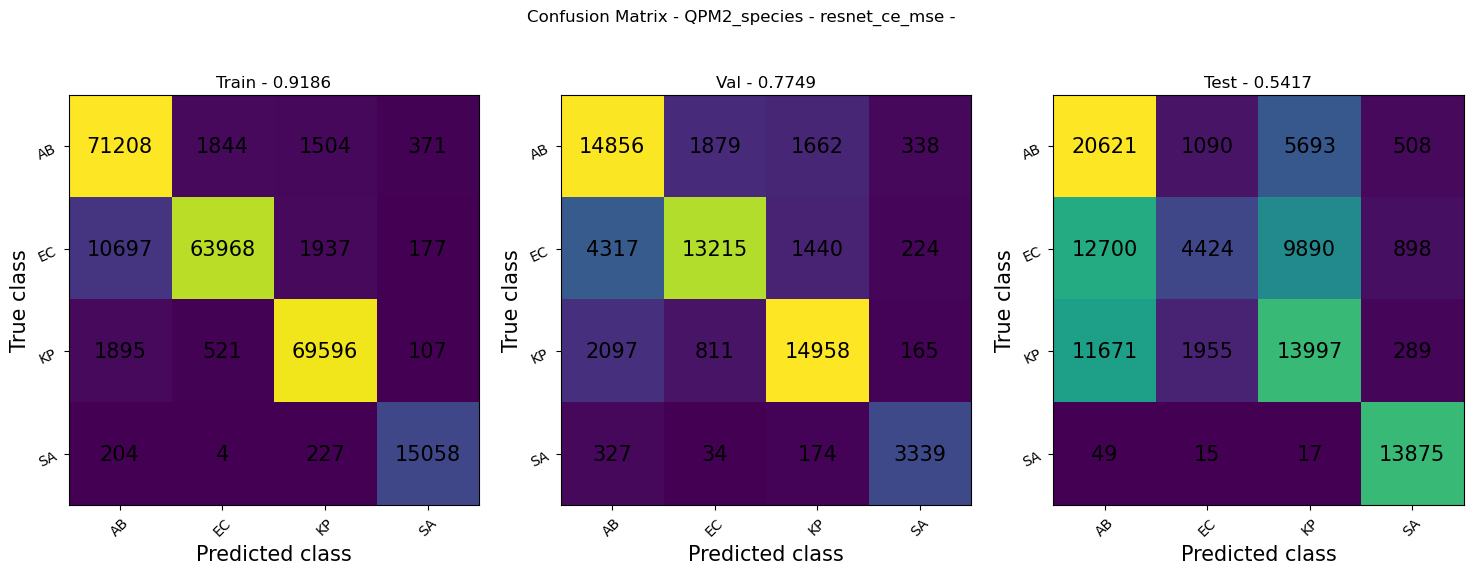

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(97692, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(97692, 2) (0, 2)


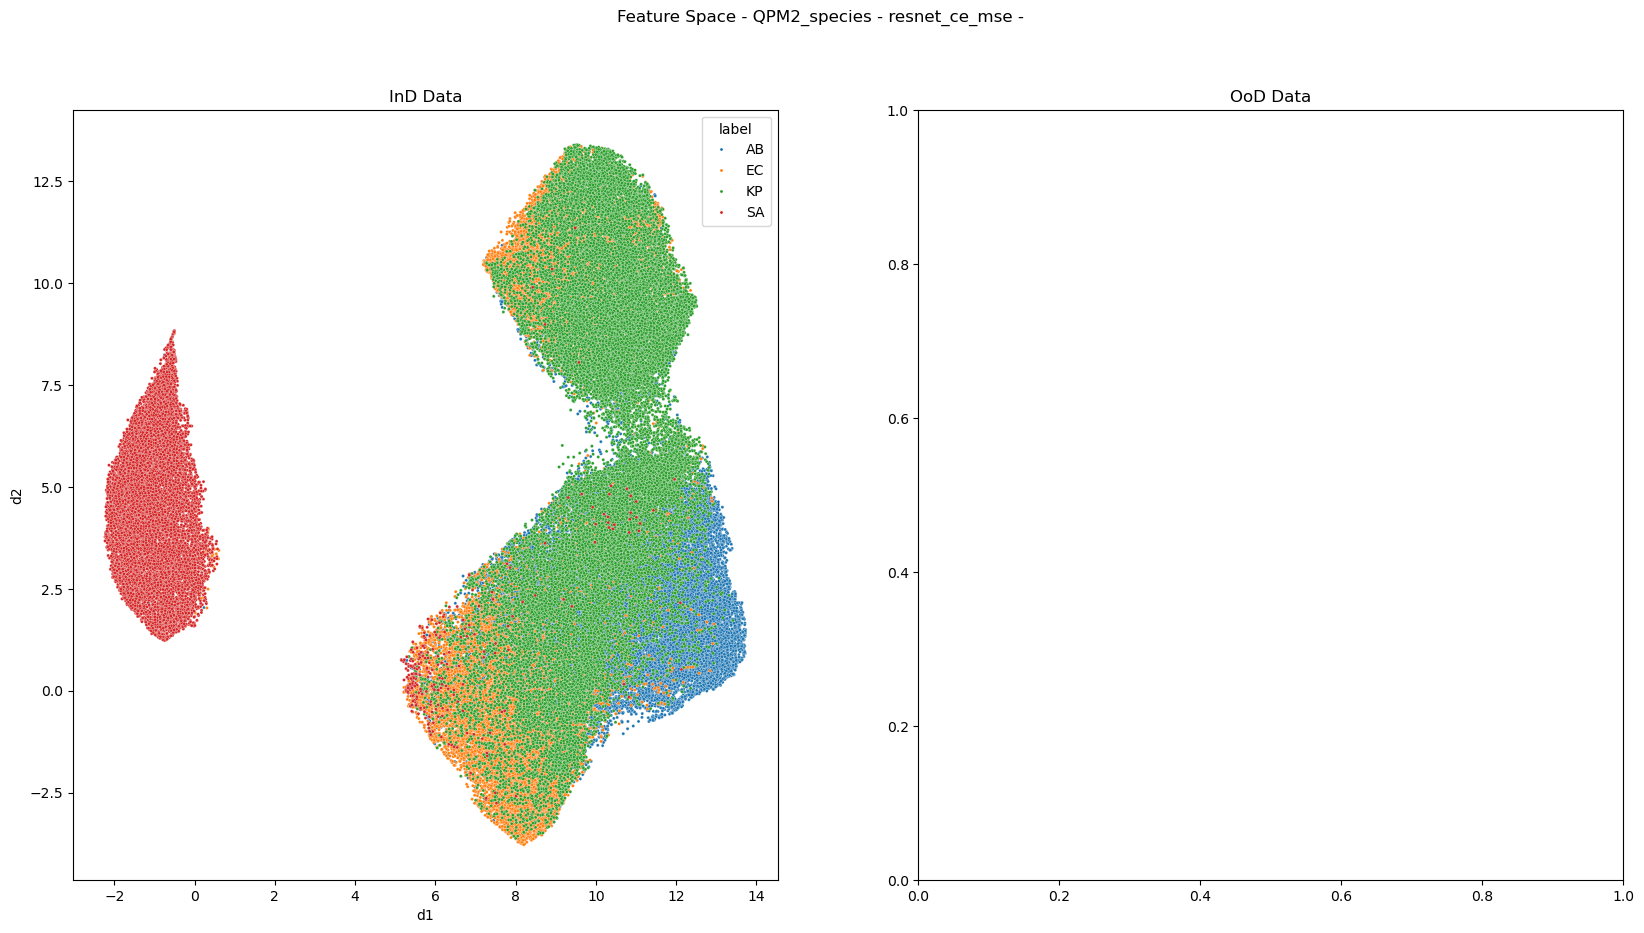

In [13]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

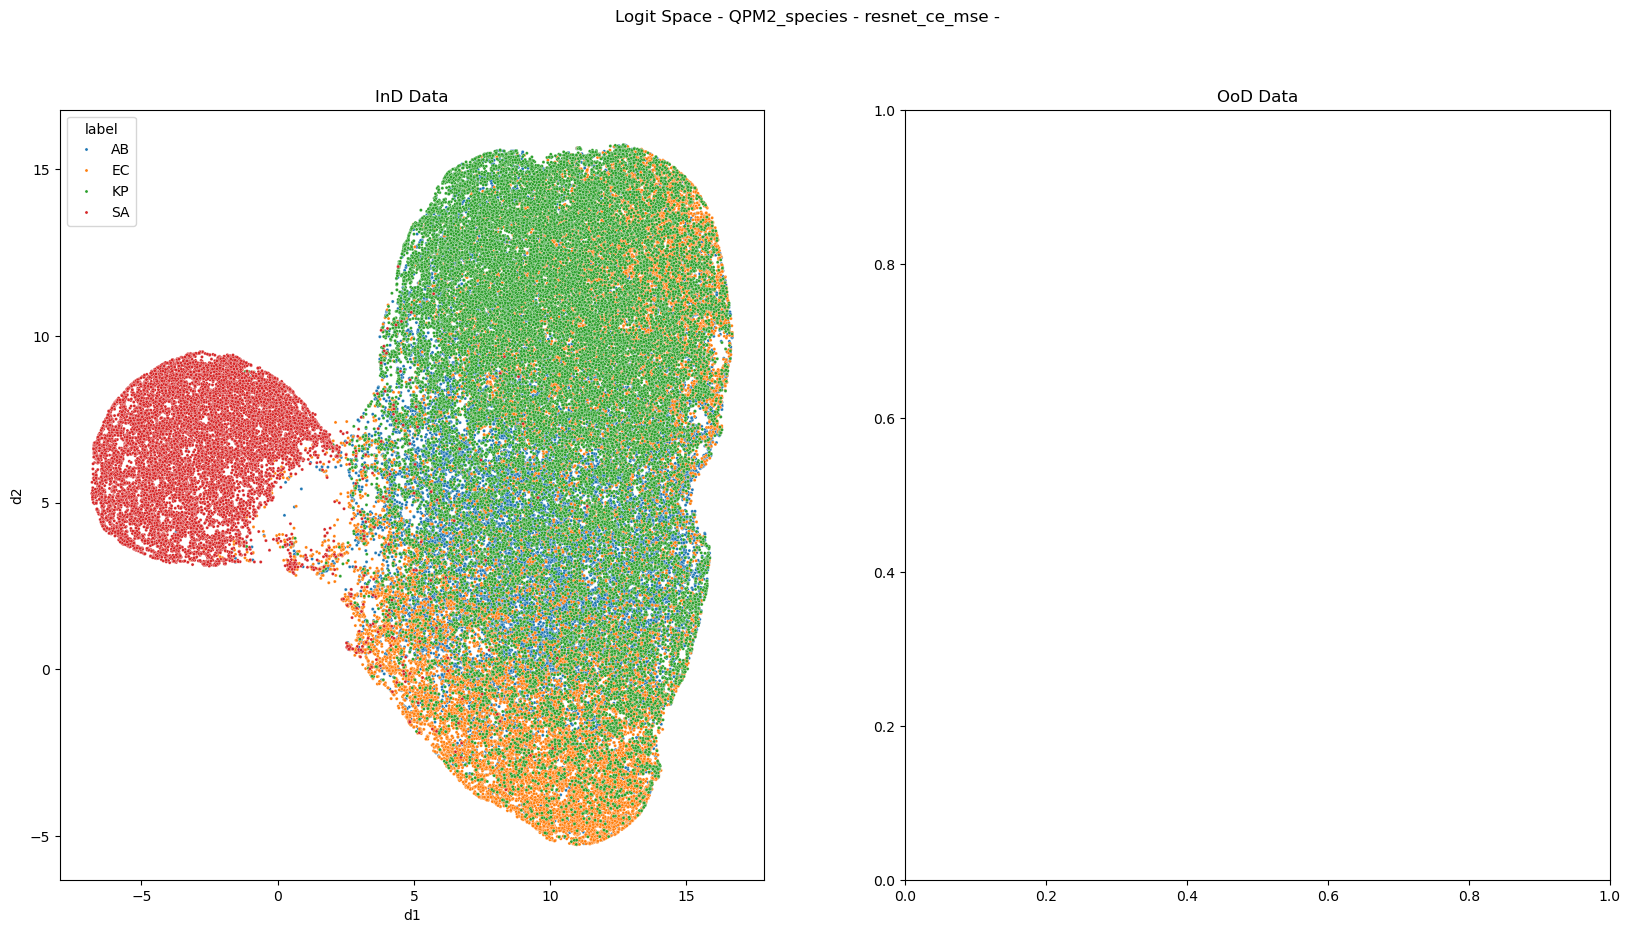

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

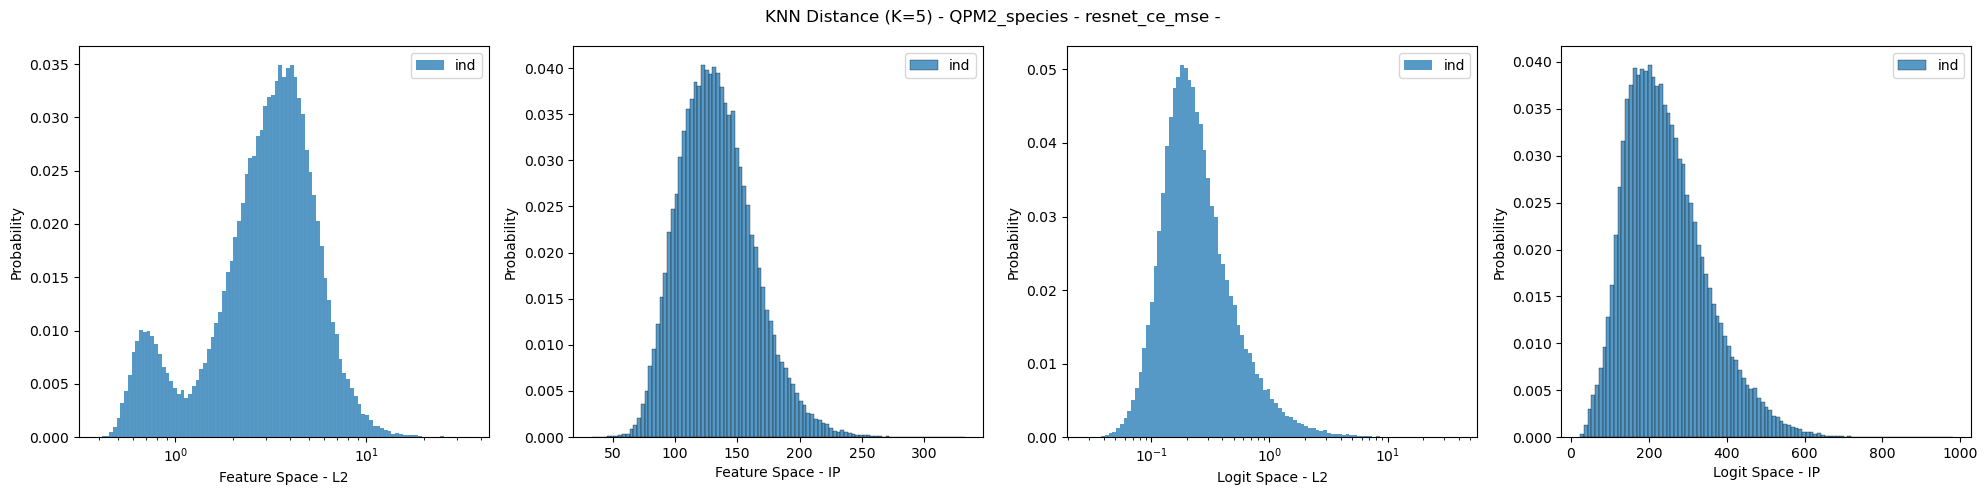

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

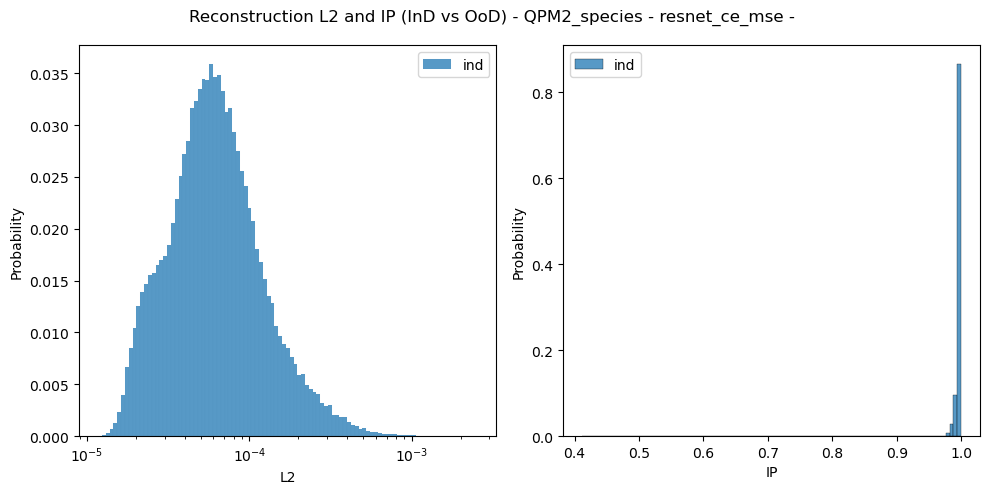

In [16]:
# plot reconstruction error of ind and ood data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_rcn.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_rcn.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

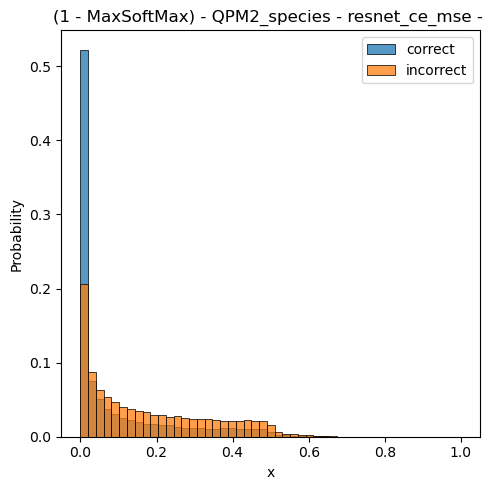

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [18]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)